In [66]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
datadir = "../data"
savedir = "../saves/catboost_tn"

if not os.path.exists(savedir):
    os.makedirs(savedir)
    
SAVE_PREFIX = os.path.join(savedir, "catboost_kf_")
from sklearn.model_selection import KFold
from catboost import Pool, CatBoostRegressor

In [60]:
NFOLDS = 5
RANDOM_SEED = 42

df_train = pd.read_csv("".join([datadir, "/singleMut_clean_train_TN.csv"]))
df_test = pd.read_csv("".join([datadir, "/singleMut_clean_test_TN.csv"]))

x_full_train = np.block(df_train[df_train.columns[:-1]])
#y_full_train = np.array(df_train.renorm_score)
y_full_train = np.array(df_train.stab_score)

x_full_test = np.block(df_test[df_test.columns[:-1]])
#y_full_test = np.array(df_test.renorm_score)
y_full_test = np.array(df_test.stab_score)

df_train

,strucType,pdbType,st_res,end_res,sec_res_type,pos_res,base_score,sec_domain_len,sec_near_T,weight,...,pkb,pkx,pH,hydroIndx,tendBury,v_deg,vanDerr,accArea,rankProp,stab_score
0,2,1,16,9,1,29,1.71,6,1,14.03,...,-0.02,0.00,0.02,21,-5.0,26,19,20,-1,1.72
1,4,4,13,2,2,22,1.21,11,5,-41.10,...,0.56,-8.83,-7.99,-41,3.0,-100,-57,-90,4,1.22
2,4,4,12,8,2,6,1.21,13,5,0.05,...,-0.18,10.53,4.09,-13,-2.1,10,21,23,3,1.20
3,2,11,3,7,1,5,1.62,5,1,-15.96,...,-0.07,-4.25,2.80,130,10.0,14,15,2,-17,1.59
4,1,14,1,14,2,26,1.15,15,3,85.11,...,-0.65,12.48,4.76,-55,-12.0,133,81,129,6,0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8534,4,4,18,11,3,30,1.21,3,0,-49.07,...,-0.31,-10.07,-0.25,-91,-0.2,-68,-45,-74,8,1.13
8535,2,1,17,3,1,38,1.71,6,2,-57.10,...,0.28,4.25,-2.67,-128,0.5,-85,-54,-79,12,0.44
8536,3,10,1,16,2,35,1.09,13,6,30.03,...,-0.59,0.00,-0.40,-28,-6.5,30,26,35,3,0.64
8537,1,3,3,15,2,17,0.85,15,3,-42.04,...,-0.52,-4.25,2.46,26,6.0,-56,-36,-58,-4,0.68


In [55]:
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_SEED)
cat_features=np.arange(x_full_train.shape[1])
NITERATIONS=1000

split_data = dict()
for fold, (train_index, test_index) in enumerate(kf.split(x_full_train)):
    split_data[fold] = (train_index, test_index)
    x_train = x_full_train[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train[test_index]
    y_val = y_full_train[test_index]
    # next model-specific
    model = CatBoostRegressor(iterations=NITERATIONS, depth=7, learning_rate=1, loss_function='RMSE',
                              metric_period=NITERATIONS//10, random_seed=RANDOM_SEED)
    #train the model
    model.fit(x_train, y_train, eval_set=(x_val, y_val))
    # make the prediction using the resulting model
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model.save_model(path)

0:	learn: 0.2405087	test: 0.2419691	best: 0.2419691 (0)	total: 3.46ms	remaining: 3.46s
100:	learn: 0.0910452	test: 0.1856113	best: 0.1856113 (100)	total: 234ms	remaining: 2.08s
200:	learn: 0.0631196	test: 0.1886805	best: 0.1856113 (100)	total: 470ms	remaining: 1.87s
300:	learn: 0.0477694	test: 0.1903736	best: 0.1856113 (100)	total: 702ms	remaining: 1.63s
400:	learn: 0.0375478	test: 0.1923747	best: 0.1856113 (100)	total: 927ms	remaining: 1.39s
500:	learn: 0.0300750	test: 0.1925489	best: 0.1856113 (100)	total: 1.18s	remaining: 1.17s
600:	learn: 0.0249627	test: 0.1931512	best: 0.1856113 (100)	total: 1.41s	remaining: 933ms
700:	learn: 0.0201711	test: 0.1940450	best: 0.1856113 (100)	total: 1.65s	remaining: 702ms
800:	learn: 0.0165406	test: 0.1944367	best: 0.1856113 (100)	total: 1.88s	remaining: 467ms
900:	learn: 0.0138206	test: 0.1949021	best: 0.1856113 (100)	total: 2.11s	remaining: 232ms
999:	learn: 0.0117185	test: 0.1950131	best: 0.1856113 (100)	total: 2.35s	remaining: 0us

bestTest = 0.1

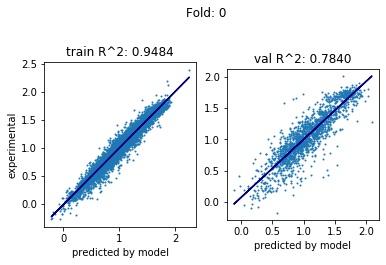

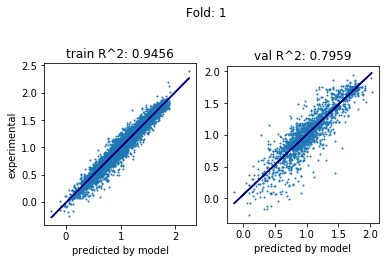

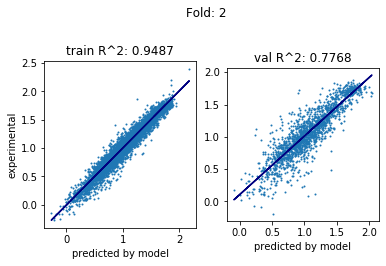

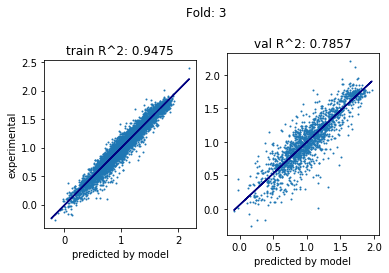

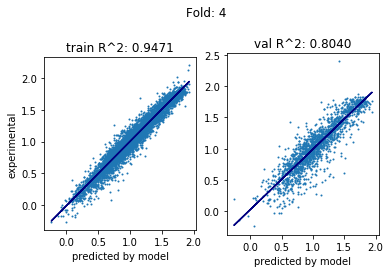

Train (using mean prediction) R^2= 0.9455564154005787
Train (using median prediction) R^2= 0.9532473000158377
Test (using mean prediction) R^2= 0.8453099667104587
Test (using median prediction) R^2= 0.8420171042249917


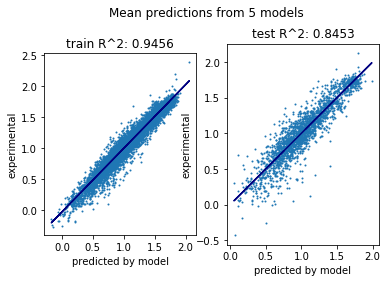

In [57]:
fold_predictions_train = []
fold_predictions_test = []
for fold in sorted(split_data):
    train_index, test_index = split_data[fold]
    x_train = x_full_train[train_index]
    y_train = y_full_train[train_index]
    x_val = x_full_train[test_index]
    y_val = y_full_train[test_index]

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model = CatBoostRegressor()
    model.load_model(path)

    pred_train = model.predict(x_train)
    pred_val = model.predict(x_val)
    pred_full_train = model.predict(x_full_train)
    pred_full_test = model.predict(x_full_test)
    fold_predictions_train.append(pred_full_train)
    fold_predictions_test.append(pred_full_test)

    fig, (ax0, ax1) = plt.subplots(ncols=2)
    ax0.scatter(pred_train, y_train, s=1)
    
    score = r2_score(y_train, pred_train)
    m, b = np.polyfit(pred_train, y_train, 1)
    
    ax0.plot(pred_train, m*pred_train + b, color="navy")
    ax0.set_aspect("equal")
    ax0.set_title(f"train R^2: {score:.4f}")
    ax0.set_xlabel("predicted by model")
    ax0.set_ylabel("experimental")

    ax1.scatter(pred_val, y_val, s=1)
    m, b = np.polyfit(pred_val, y_val, 1)
    ax1.plot(pred_val, m*pred_val + b, color="navy")
    
    ax1.set_aspect("equal")
    score = r2_score(y_val, pred_val)
    ax1.set_title(f"val R^2: {score:.4f}");
    ax1.set_xlabel("predicted by model")
    plt.suptitle(f"Fold: {fold}")
    plt.show()
    plt.close(fig)

train_predictions_mean = np.stack(fold_predictions_train).mean(0)
test_predictions_mean = np.stack(fold_predictions_test).mean(0)
train_predictions_median = np.median(np.stack(fold_predictions_train), 0)
test_predictions_median = np.median(np.stack(fold_predictions_test), 0)

print("Train (using mean prediction) R^2=", r2_score(y_full_train, train_predictions_mean))
print("Train (using median prediction) R^2=", r2_score(y_full_train, train_predictions_median))

print("Test (using mean prediction) R^2=", r2_score(y_full_test, test_predictions_mean))
print("Test (using median prediction) R^2=", r2_score(y_full_test, test_predictions_median))

# the same plots for mean predictions - on train and test datasets:
fig, (ax0, ax1) = plt.subplots(ncols=2)
## train
ax0.scatter(train_predictions_mean, y_full_train, s=1)

score = r2_score(y_full_train, train_predictions_mean)
m, b = np.polyfit(train_predictions_mean, y_full_train, 1)

ax0.plot(train_predictions_mean, m*train_predictions_mean + b, color="navy")
ax0.set_aspect("equal")
ax0.set_title(f"train R^2: {score:.4f}")
ax0.set_xlabel("predicted by model")
ax0.set_ylabel("experimental")

## test
ax1.scatter(test_predictions_mean, y_full_test, s=1)

score = r2_score(y_full_test, test_predictions_mean)
m, b = np.polyfit(test_predictions_mean, y_full_test, 1)

ax1.plot(test_predictions_mean, m*test_predictions_mean + b, color="navy")
ax1.set_aspect("equal")
ax1.set_title(f"test R^2: {score:.4f}")
ax1.set_xlabel("predicted by model")
ax1.set_ylabel("experimental");
plt.suptitle(f"Mean predictions from {NFOLDS} models");



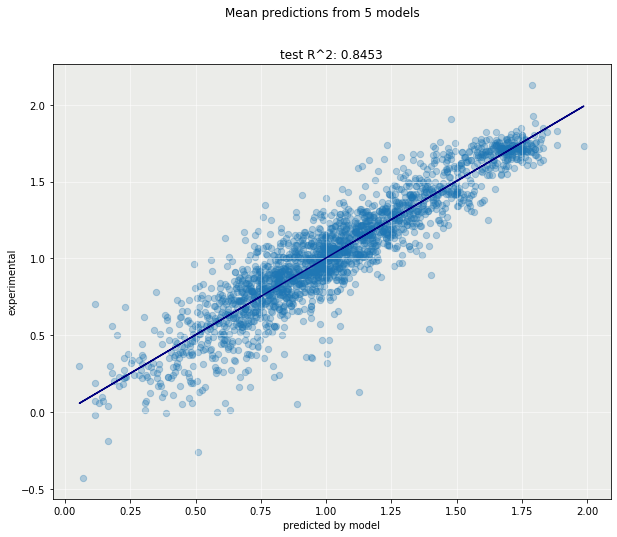

In [116]:
plt.figure(figsize=(10,8))

ax = plt.axes()
ax.set_facecolor("#EBECE9")

plt.scatter(test_predictions_mean, y_full_test, s=40, alpha=0.3)

score = r2_score(y_full_test, test_predictions_mean)
m, b = np.polyfit(test_predictions_mean, y_full_test, 1)
plt.grid(False, linewidth=0.5, color='#ffffff', linestyle='-')

plt.plot(test_predictions_mean, m*test_predictions_mean + b, color="navy")
plt.title(f"test R^2: {score:.4f}")
plt.xlabel("predicted by model")
plt.ylabel("experimental");
plt.suptitle(f"Mean predictions from {NFOLDS} models");

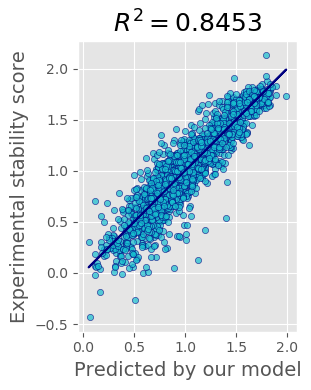

In [117]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
model = ols.fit(test_predictions_mean.reshape(-1, 1), y_full_test.reshape(-1, 1))
response = model.predict(test_predictions_mean.reshape(-1, 1))
r2 = r2_score(y_full_test, test_predictions_mean)
plt.style.use('default')
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(test_predictions_mean, response, color='navy', label='Regression model')
ax.scatter(test_predictions_mean, y_full_test, edgecolor='navy',
           facecolor='tab:cyan', s= 20,
           alpha=0.7, label='Sample data')
ax.set_ylabel('Experimental stability score', fontsize=14)
ax.set_xlabel('Predicted by our model', fontsize=14)
#ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.4f$' % r2, fontsize=18)
ax.set_aspect("equal")
fig.tight_layout()

In [58]:
model_all_data = CatBoostRegressor(
    iterations=NITERATIONS, depth=7, learning_rate=1, loss_function='RMSE',
    metric_period=NITERATIONS//10
)
model_all_data.fit(x_full_train, y_full_train, eval_set=(x_full_train, y_full_train))
path = f"{SAVE_PREFIX}all.cbm"
model_all_data.save_model(path)
predictions = model_all_data.predict(x_full_test)
score=r2_score(y_full_test, predictions)
print("R^2 score on test set:", score)

0:	learn: 0.2264874	test: 0.2264874	best: 0.2264874 (0)	total: 4.28ms	remaining: 4.28s
100:	learn: 0.0995718	test: 0.0995718	best: 0.0995718 (100)	total: 258ms	remaining: 2.3s
200:	learn: 0.0733854	test: 0.0733854	best: 0.0733854 (200)	total: 512ms	remaining: 2.03s
300:	learn: 0.0562447	test: 0.0562447	best: 0.0562447 (300)	total: 763ms	remaining: 1.77s
400:	learn: 0.0453439	test: 0.0453439	best: 0.0453439 (400)	total: 1.02s	remaining: 1.52s
500:	learn: 0.0373968	test: 0.0373968	best: 0.0373968 (500)	total: 1.27s	remaining: 1.27s
600:	learn: 0.0314082	test: 0.0314082	best: 0.0314082 (600)	total: 1.55s	remaining: 1.03s
700:	learn: 0.0268149	test: 0.0268149	best: 0.0268149 (700)	total: 1.84s	remaining: 786ms
800:	learn: 0.0229560	test: 0.0229560	best: 0.0229560 (800)	total: 2.09s	remaining: 520ms
900:	learn: 0.0196285	test: 0.0196285	best: 0.0196285 (900)	total: 2.35s	remaining: 258ms
999:	learn: 0.0171173	test: 0.0171173	best: 0.0171173 (999)	total: 2.6s	remaining: 0us

bestTest = 0.017

In [119]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + '')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURES')

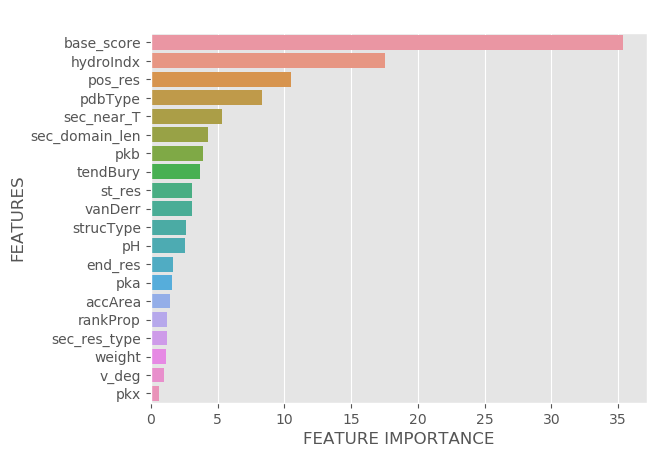

In [120]:
for fold in sorted(split_data):

    path = f"{SAVE_PREFIX}{fold}.cbm"
    model = CatBoostRegressor()
    model.load_model(path)
    
    plot_feature_importance(model.get_feature_importance(), df_train.columns[:-1],' ')
    #plt.show()
    #plt.close(fig)

